# ISO Playlists EDA
\author{Alan Sun}
- Preprocessing
- Exploratory Data Analysis
- Conclusions and Evaluation

In [1]:
import requests
import threading
from requests_oauthlib import OAuth1
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import random

In [2]:
API_TOKEN = open('api').readline()
SOAR_ID = "etoj1vywg8pvjmuxgovg6l9kb"
headers = {"Authorization": f"Bearer {API_TOKEN}"}

Get all of the playlists in the user's profile.

In [3]:
url = f"https://api.spotify.com/v1/users/{SOAR_ID}/playlists"
playlists = requests.get(url, headers=headers, params={'limit': 50}).json()
playlist_ids = [v['id'] for v in playlists['items']]
playlist_descriptions = [v['name'] + ' - ' + v['description'] for v in playlists['items']]

In [4]:
playlist_descriptions

['iso30 - nervous, agitated, energetic to calm, relaxed, soothed',
 'iso29 - tender to powerful',
 'iso28 - happy to powerful',
 'iso27 - happy to tender',
 'iso26 - sad to powerful',
 'iso25 - sad to tender',
 'iso24 - sad to happy',
 'iso23 - tense to powerful',
 'iso22 - tense to tender',
 'iso21 - tense to happy',
 'iso20 - anxious to meditative to relaxed',
 'iso19 - melancholic to tender to affectionate',
 'iso18 - irritated to meditative to soothed',
 'iso17 - serene to animated to energetic',
 'iso16 - sad to animated to joyful',
 'iso15 - tenderness to joyful to energetic',
 'iso14 - energetic to dreamy to relaxed',
 'iso13 - nervous to animated to energetic',
 'iso12 - angry to amused to soothed',
 'iso11 - sad to soothed to triumphant',
 'iso10 - anxious to relaxed to joyful',
 'iso09 - sad to happy',
 'iso08 - nervous to calm',
 'iso07 - sluggish to energized',
 'iso06 - Sad to Hopeful',
 'iso05 - lonely to connected',
 'iso04 - calm, dreamy, melancholic to calm, relaxed, m

After we get all of the playlist IDs, we now need to get the track ID of all of the tracks in each playlist. (*TODO: with more data it would probably be a good idea to multithread the requests*)

In [5]:
labeled_data = {}

def get_playlist_info(playlist_id, playlist_description,
                      headers, lock):
    url = f"https://api.spotify.com/v1/playlists/{playlist_id}/tracks"
    tracks = requests.get(url, headers=headers)
    tracks = tracks.json()
    track_ids = [p['track']['id'] for p in tracks['items']]
    lock.acquire()
    labeled_data[playlist_description] = track_ids
    lock.release()

# Create threads
threads = []
lock = threading.Lock()
for pid, pdescript in zip(playlist_ids, playlist_descriptions):
    threads.append(threading.Thread(target=get_playlist_info,
                                    args=(pid, pdescript, headers, lock)))
# Start threads
for thread in threads:
    thread.start()

# Join threads
for thread in threads:
    thread.join()

In [6]:
json.dump(labeled_data, open("data/playlist-tracks-id", "w+"))

Now we get all of the audio features associated with each track in a playlist.

In [7]:
features = {}

def get_audio_features(playlist, track_ids, headers, lock):
    audio_feature_request = {'ids':','.join(track_ids)}
    audio_url = "https://api.spotify.com/v1/audio-features"
    aud_features = requests.get(audio_url, headers=headers, 
                 params=audio_feature_request)
    aud_features = aud_features.json()['audio_features']
    lock.acquire()
    features[playlist] = aud_features
    lock.release()

# Create threads
threads = []
lock = threading.Lock()
for k, v in labeled_data.items():
    threads.append(threading.Thread(target=get_audio_features,
                                    args=(k, v, headers, lock)))
# Start threads
for thread in threads:
    thread.start()

# Join threads
for thread in threads:
    thread.join()

In [8]:
json.dump(features, open("data/playlist-tracks-features", "w+"))

In [9]:
features.keys()

dict_keys(['iso27 - happy to tender', 'iso29 - tender to powerful', 'iso26 - sad to powerful', 'iso23 - tense to powerful', 'iso30 - nervous, agitated, energetic to calm, relaxed, soothed', 'iso28 - happy to powerful', 'iso19 - melancholic to tender to affectionate', 'iso22 - tense to tender', 'iso24 - sad to happy', 'iso18 - irritated to meditative to soothed', 'iso25 - sad to tender', 'iso17 - serene to animated to energetic', 'iso20 - anxious to meditative to relaxed', 'iso15 - tenderness to joyful to energetic', 'iso14 - energetic to dreamy to relaxed', 'iso11 - sad to soothed to triumphant', 'iso16 - sad to animated to joyful', 'iso21 - tense to happy', 'iso13 - nervous to animated to energetic', 'iso12 - angry to amused to soothed', 'iso09 - sad to happy', 'iso05 - lonely to connected', 'iso10 - anxious to relaxed to joyful', 'iso06 - Sad to Hopeful', 'iso08 - nervous to calm', 'iso07 - sluggish to energized', 'iso03 - anxious to calm, motivated', 'iso04 - calm, dreamy, melanchol

In [10]:
features['iso09 - sad to happy'][0].keys()

dict_keys(['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'type', 'id', 'uri', 'track_href', 'analysis_url', 'duration_ms', 'time_signature'])

We now plot the individual metrics as a function of the song time step.

In [11]:
def plot_attribute(attribute, features):
    plt.figure(figsize=(40, 20), constrained_layout=True)
    fig, ax = plt.subplots(6, 3)
    fig.suptitle(f"{attribute} vs. time step of a given playlist")
    fig.set_size_inches(18.5, 10.5)
    nonempty_keys = [v for v in features.keys() if features[v] != [None]]
    # plot valence
    ax_num = 1
    for i in range(6):
        for j in range(3):
            axis = ax[i][j]
            feature = features[nonempty_keys[i]]
            featvs_time = [v[attribute] for v in feature]
            axis.plot(featvs_time)
            axis.set_title(nonempty_keys[i], fontsize=10)
            axis.axes.get_xaxis().set_visible(False)
    plt.show()

<Figure size 2880x1440 with 0 Axes>

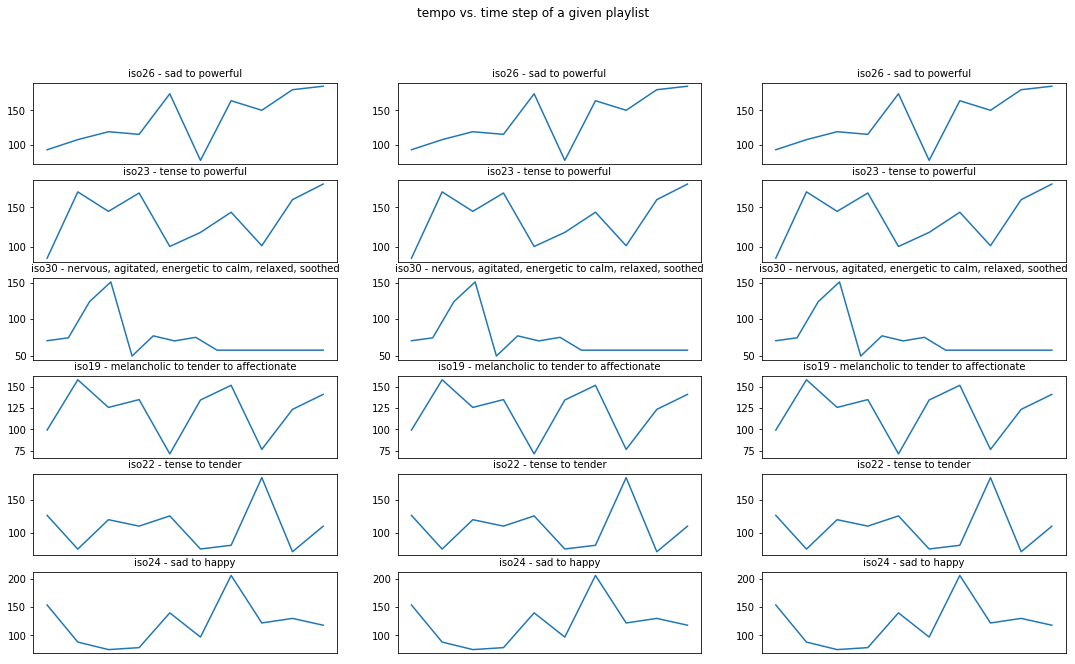

In [13]:
plot_attribute('tempo', features)

## Conclusion and Evaluation
From our generated graphs we see apparent correlations between the various features: valence, danceability, energy, and the moods that the playlists supposedly emmulate. Moving forward, this demonstrates that we may be able to create synthetic data through simple linear regression techniques. Generally, we see that many of the curves present look logarithmic. Thus, may be represented using the general form: 
$$a\cdot \frac{\log{x}}{\log b} + c, \qquad a, b, c \in \mathbb{R}.$$

One limitation to such a regression is that it is also not a function of specified input length.

Further EDA needs to be done on keyword clustering – currently, the various graphs for each projected curve is jagged, graphs and their respective data points can be averaged together based on the various starting keywords and ending keywords.

# Spotify Playlist Query Based on Audio Features
In this section, we examine the efficacy of spotify queries based on Spotify extracted audio features. We start by going through each playlist querying the target feature based on the exact extracted audio feature. Then, we increase the testing range by using the min, max feature queries. The efficacy of each test is measured by whether or not the target track appears in the top 1, 5, 10, 20 returned results.

The Spotify `recommendations` API endpoint has 3 required fields: `seed_artists`, `seed_genres`, `seed_tracks`. My understanding of these seeds are that they provide a reference point for Spotify to begin searching the space of possible song which match the other `recommendation` criterions.

In [16]:
# we start by getting the *fixed* genre recommendations from spotify
# we probably want the user to choose this at the initialiation of the app.
url = "https://api.spotify.com/v1/recommendations/available-genre-seeds"
genres = requests.get(url, headers=headers).json()['genres']

# we choose 3 random genres
genres = 'acoustic,pop,indie'
url = 'https://api.spotify.com/v1/recommendations'      
ld = [v for v in labeled_data if len(labeled_data[v]) != 0]

In [17]:
def get_recommendation(protuberance=0.):
    # choose a playlist with non-zero features
    ld = [v for v in labeled_data if len(labeled_data[v]) != 0]
    ref = ld
    iso = random.randint(0, len(ref))
    removed = ref.pop(iso)
    # get random track for search
    i = random.randint(0, 9)
    trackid = labeled_data[ref[iso]][i]
    feature = features[ref[iso]][i]
    feature.pop('id', None); feature.pop('type', None); feature.pop('uri', None)
    feature.pop('track_href', None); feature.pop('analysis_url', None)
    feature.pop('duration_ms', None)
    # these three playlists
    playlists = [random.randint(0, len(ld) - 1) for i in range(2)]

    # get seed tracks
    r_tracks = [labeled_data[ld[playlists[i]]][random.randint(0, 9)] 
                for i in range(1)]

    # get artists from seed tracks and query
    urls = [f'https://api.spotify.com/v1/tracks/{id}'
            for id in r_tracks]
    reqst = [requests.get(url, headers=headers).json() for url in urls]
    artists = [r['album']['artists'][0]['id'] for r in reqst]

    # make requests
    params = {f'target_{k}': v + v * protuberance
              for k, v in feature.items()}
    # round integer fields -> 
    params['target_key'] = round(params['target_key'])
    params['target_mode'] = round(params['target_mode'])
    params['target_time_signature'] = round(params['target_time_signature'])
    params['seed_artists'] = ','.join(artists)
    params['seed_tracks'] = ','.join(r_tracks)
    params['seed_genres'] = genres
    reqst = requests.get(url, headers=headers, params=params)
    reqst = reqst.json()
    return get_track_name(trackid, reqst['tracks'][0]['id'])

In [18]:
def get_track_name(id1, id2):
    params = {'ids': ','.join([id1, id2])}
    req = requests.get('https://api.spotify.com/v1/tracks', 
                       headers=headers, params=params).json()
    return ((req['tracks'][0]['name'], req['tracks'][0]['artists'][0]['name']), 
           (req['tracks'][1]['name'], req['tracks'][1]['artists'][0]['name']))

## Exact Feature Query (+0%)

We search / get recommendations based on all of the features returned by Spotify's audio analysis. Here, just to gauge the accuracy of Spotify's recommendation system, we query with the exact audio features and then slowly increase the level of uncertainty. We note that in all of the proceeding experiments, the first tuple in the returned two dimensional tuple is the song that is used for querying, the second tuple in the returned two dimensional tuple is the song that was returned as a result of querying.

In [19]:
get_recommendation()

(('3a1vk5zuTpm3Z2K9bJM7kg', 'Ambrose Akinmusire'),
 ('5k7VKj1Xwy5DjO4B0PdAOb', 'Radiohead'))

In [148]:
get_recommendation()

(('Honest', 'JOSEPH'), ('Breakeven', 'Kurt Hugo Schneider'))

In [149]:
get_recommendation()

(('Circles', 'Post Malone'), ('Bonfire Heart', 'James Blunt'))

In [150]:
get_recommendation()

(('Island Feeling', 'Dave Holland'), ('Heart Skipped a Beat', 'The xx'))

In [152]:
get_recommendation()

(('Anxiety (with Selena Gomez)', 'Julia Michaels'),
 ('Down the Line', 'Beach Fossils'))

## Approximate Feature Query (+3%)

In [153]:
get_recommendation(protuberance=0.03)

(('A Lovely Night', 'Ryan Gosling'), ('What Other People Say', 'Sam Fischer'))

In [154]:
get_recommendation(protuberance=0.03)

(('Feel The Need', 'Eryn Allen Kane'), ('good 4 u', 'Olivia Rodrigo'))

In [155]:
get_recommendation(protuberance=0.03)

(('All of Us', 'Pat Metheny/Ornette Coleman'), ('That Easy', 'Yellow Days'))

In [156]:
get_recommendation(protuberance=0.03)

(('Brave', 'Sara Bareilles'), ('All Around The World', 'Justin Bieber'))

In [157]:
get_recommendation(protuberance=0.03)

(('Strawberry Swing', 'Coldplay'),
 ('Good Life (with G-Eazy & Kehlani)', 'G-Eazy'))

## Approximate Feature Query (+5%)

In [159]:
get_recommendation(protuberance=0.05)

(("Let's Fall in Love for the Night", 'FINNEAS'), ('Drive', 'Oh Wonder'))

In [160]:
get_recommendation(protuberance=0.05)

(('Glory of Music', 'The Head And The Heart'),
 ('Hey There Delilah', "Plain White T's"))

In [161]:
get_recommendation(protuberance=0.05)

(("(What's So Funny 'Bout) Peace, Love and Understanding?",
  'Sharon Van Etten'),
 ('Hold Me', 'The Sweeplings'))

In [162]:
get_recommendation(protuberance=0.05)

(('Good Day', 'Surfaces'), ('Islands', 'The xx'))

In [163]:
get_recommendation(protuberance=0.05)

(('Mellomaniac - Chillout Mix', 'DJ Shah'),
 ('Pray For Me (with Kendrick Lamar)', 'The Weeknd'))

## Approximate Feature Query (+7%)

In [164]:
get_recommendation(protuberance=0.07)

(('Fake', 'Lauv'), ('Saw You In A Dream', 'The Japanese House'))

In [165]:
get_recommendation(protuberance=0.07)

(("I'll Get Along", 'Michael Kiwanuka'), ('Sunflower Seeds', 'Bryce Vine'))

In [166]:
get_recommendation(protuberance=0.07)

(('Another Night on Mars', 'The Maine'), ('FRIENDS', 'LAUNDRY DAY'))

In [167]:
get_recommendation(protuberance=0.07)

(('Não Faz Sentido', 'MARO'), ('Teach You - Acoustic', 'Emily King'))

In [168]:
get_recommendation(protuberance=0.07)

(('Parachute', 'Ingrid Michaelson'),
 ("There's No Business Like Show Business", 'Ethel Merman'))

## Approximate Feature Query (+10%)

In [169]:
get_recommendation(protuberance=0.1)

(('Holy (feat. Chance The Rapper)', 'Justin Bieber'),
 ('Got It In You', 'BANNERS'))

In [170]:
get_recommendation(protuberance=0.1)

(('Better Now', 'Post Malone'),
 ("You're the Inspiration - 2006 Remaster", 'Chicago'))

In [171]:
get_recommendation(protuberance=0.1)

(('Lonesome', 'Kina Grannis'), ('Lose Somebody', 'Kygo'))

In [172]:
get_recommendation(protuberance=0.1)

(('Shake It Off', 'Taylor Swift'), ('Daft Pretty Boys', 'Bad Suns'))

In [173]:
get_recommendation(protuberance=0.1)

(('I Can Change', 'Lake Street Dive'), ('You and I', 'Ingrid Michaelson'))

## Approximate Feature Query (+12%)

In [174]:
get_recommendation(protuberance=0.12)

(('You Make My Dreams (Come True)', 'Daryl Hall & John Oates'),
 ('Punto G', 'KAROL G'))

In [177]:
get_recommendation(protuberance=0.12)

(('Skinny Love', 'Birdy'), ('Someone Like You', 'Adele'))

In [176]:
get_recommendation(protuberance=0.12)

(("Things Won't Go My Way", 'Peach Tree Rascals'), ('talk', 'keshi'))

In [178]:
get_recommendation(protuberance=0.12)

(('Time To Rest Your Weary Head', 'Jacob Collier'),
 ('Become the Warm Jets', 'Current Joys'))

In [179]:
get_recommendation(protuberance=0.12)

(('Some Nights', 'fun.'), ('Conscious Club', 'Vulfpeck'))

## Approximate Feature Query (+15%)

In [180]:
get_recommendation(protuberance=0.15)

(('Fake', 'Lauv'), ('Crash My Car', 'COIN'))

In [181]:
get_recommendation(protuberance=0.15)

(('Here Comes the Sun', 'Imaginary Future'),
 ('Here Comes the Sun', 'Imaginary Future'))

In [182]:
get_recommendation(protuberance=0.15)

(('Light On', 'Maggie Rogers'),
 ('San Andreas End Credits', 'Andrew Lockington'))

In [183]:
get_recommendation(protuberance=0.15)

(('Tattoos Together', 'Lauv'), ('Free', 'Donavon Frankenreiter'))

In [185]:
get_recommendation(protuberance=0.15)

(('End Of The Day', 'Beck'), ('11 Hours - Branchez Remix', 'Wet'))

## Approximate Feature Query (+20%)

In [188]:
get_recommendation(protuberance=0.20)

(('In Too Deep (feat. Kiana Ledé)', 'Jacob Collier'),
 ("Naïve - BBC Radio 1's Jo Whiley's Live Lounge", 'Lily Allen'))

In [187]:
get_recommendation(protuberance=0.20)

(('Riverside', 'Agnes Obel'), ("Body Ain't Me", 'Pink Sweat$'))

In [189]:
get_recommendation(protuberance=0.20)

(('Na Na Na', 'Pentatonix'), ('1999 WILDFIRE', 'BROCKHAMPTON'))

In [190]:
get_recommendation(protuberance=0.20)

(('My Silver Lining', 'First Aid Kit'),
 ('Just to Satisfy You', 'Paula Nelson'))

In [192]:
get_recommendation(protuberance=0.20)

(('Tattoos Together', 'Lauv'), ('1999 WILDFIRE', 'BROCKHAMPTON'))